## Business Context

To develop a model predicting fradulent transactions for a financial company and use insights from the model to develop an actionable plan.

## Data Preprocessing

### Importing required libraries

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [210]:
df=pd.read_csv('Fraud.csv')

In [211]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Data Description
* step - maps a unit of time in the real world. In this case 1 step means 1 hour of time. Total steps 744 (30 days simulation)
* type - cash in, cash out, debit, payment and transfer
* amount -  amount of transaction in local currency
* nameOrig -  customer who started the transaction
* oldbalanceOrig - initial balance before transaction
* newbalanceOrig - new balance after transaction
* nameDest - who is the recipient of the transaction
* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Checking for null values

In [213]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [214]:
df.duplicated().sum()

0

### Checking for outliers

In [215]:
df['step'].describe()

count    6.362620e+06
mean     2.433972e+02
std      1.423320e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.350000e+02
max      7.430000e+02
Name: step, dtype: float64

In [216]:
# to get the upper boundary, lower boundary
q3,q1=np.percentile(df['step'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr

In [217]:
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  603.5 lower threshold:  66.5


In [218]:
df[df['step']>upper_threshold]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6259932,604,TRANSFER,714218.48,C454938739,714218.48,0.0,C482986731,0.00,0.00,1,0
6259933,604,CASH_OUT,714218.48,C1835708623,714218.48,0.0,C1881116283,106940.83,821159.31,1,0
6259934,604,TRANSFER,277582.53,C2144116571,277582.53,0.0,C570246252,0.00,0.00,1,0
6259935,604,CASH_OUT,277582.53,C1512896686,277582.53,0.0,C731882373,0.00,277582.53,1,0
6259936,604,TRANSFER,4672401.04,C801580496,4672401.04,0.0,C1917884973,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [219]:
(df[df['step']>upper_threshold].shape[0]/df.shape[0])*100

1.6139263385209237

* out of 63,62,619 rows,  102688 rows are having values step value greater than upper threshold , i.e 1.6% of the total dataset

In [220]:
(df[df['step']<lower_threshold].shape[0]/df.shape[0])*100

16.19582813369335

* 16% of the total dataset are less than the lower threshold

In [221]:
# for amount variable
q3,q1=np.percentile(df['amount'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr

In [222]:
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  501719.33875 lower threshold:  -84276.38375000001


In [223]:
(df[df['step']>upper_threshold].shape[0]/df.shape[0])*100 

0.0

In [224]:
(df[df['step']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* no outliers in 'amount' variable

In [225]:
# for oldbalanceOrg
q3,q1=np.percentile(df['oldbalanceOrg'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  268287.9375 lower threshold:  -53657.58750000001


In [226]:
(df[df['oldbalanceOrg']>upper_threshold].shape[0]/df.shape[0])*100 

17.485045468690572

In [227]:
(df[df['oldbalanceOrg']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* 17% of data has oldbalanceOrg greater than upper threshold value

In [228]:
# for newbalanceOrig
q3,q1=np.percentile(df['newbalanceOrig'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  360646.025 lower threshold:  -72129.20499999999


In [229]:
(df[df['newbalanceOrig']>upper_threshold].shape[0]/df.shape[0])*100 

16.5559313616089

In [230]:
(df[df['newbalanceOrig']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* 16.5% of data has newbalanceOrig greater than upper threshold value

In [231]:
# for oldbalanceDest
q3,q1=np.percentile(df['oldbalanceDest'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  2357591.76875 lower threshold:  -471518.35375


In [232]:
(df[df['oldbalanceDest']>upper_threshold].shape[0]/df.shape[0])*100 

12.355523353587044

In [233]:
(df[df['oldbalanceDest']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* 12.35% of data has oldbalanceDest greater than upper threshold value

In [234]:
# for newbalanceDest
q3,q1=np.percentile(df['newbalanceDest'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  2779773.125 lower threshold:  -555954.625


In [235]:
(df[df['newbalanceDest']>upper_threshold].shape[0]/df.shape[0])*100 

11.60727813385052

In [236]:
(df[df['newbalanceDest']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* 11.6% of data has newbalanceDest greater than upper threshold value

In [237]:
# for isFraud 
q3,q1=np.percentile(df['isFraud'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  0.0 lower threshold:  0.0


In [238]:
(df[df['isFraud']>upper_threshold].shape[0]/df.shape[0])*100 

0.12908204481801522

In [239]:
(df[df['isFraud']<lower_threshold].shape[0]/df.shape[0])*100

0.0

* only 0.12% of data has isFraud greater then upper threshold value which is very less.

In [240]:
# for isFlaggedFraud
q3,q1=np.percentile(df['isFlaggedFraud'],[75,25])
iqr=q3-q1
upper_threshold=q3+1.5*iqr
lower_threshold=q3-1.5*iqr
print("upper threshold: ",upper_threshold,"lower threshold: ",lower_threshold)

upper threshold:  0.0 lower threshold:  0.0


In [241]:
(df[df['isFlaggedFraud']>upper_threshold].shape[0]/df.shape[0])*100

0.000251468734577894

In [242]:
(df[df['isFlaggedFraud']<lower_threshold].shape[0]/df.shape[0])*100

0.0

1. 16% of data has step greater than upper threshold value
2. no outliers in 'amount' variable
3. 17% of data has oldbalanceOrg greater than upper threshold value
4. 16.5% of data has newbalanceOrig greater than upper threshold value
5. 12.35% of data has oldbalanceDest greater than upper threshold value
6. 11.6% of data has newbalanceDest greater than upper threshold value
7. only 0.12% of data has isFraud greater then upper threshold value which is very less.
8. very very less amount of data has isFlaggedFraud greater than upper threshold value.

In [243]:
numerical=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

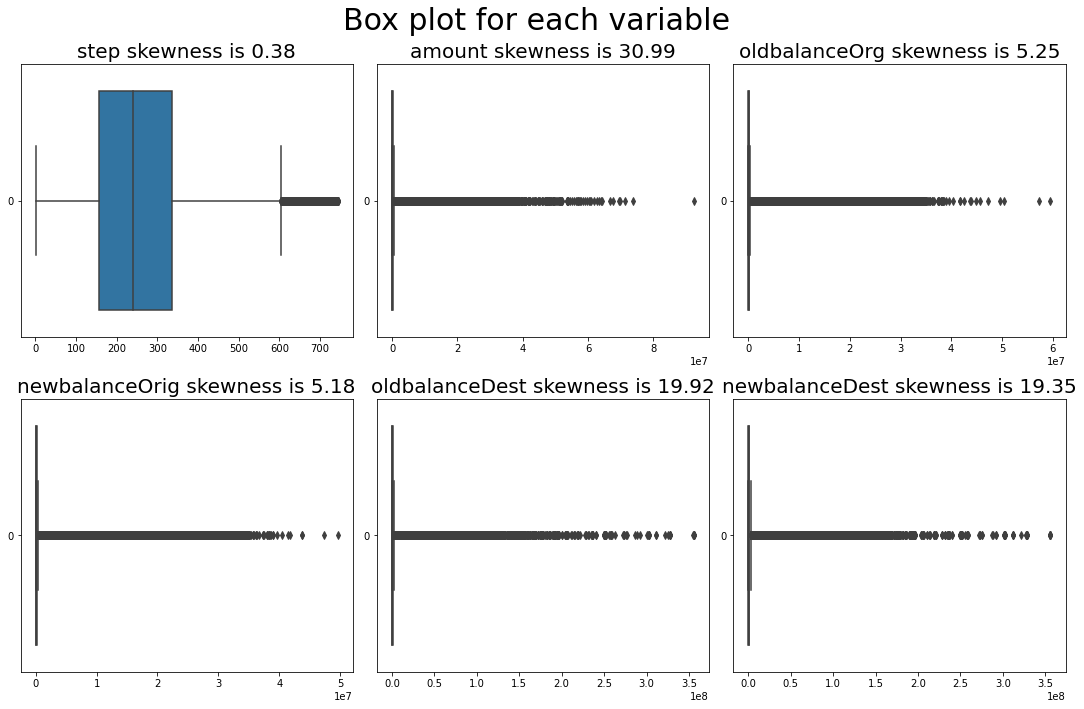

In [244]:
def visualize_boxplots(data,column):
    fig,ax=plt.subplots(2,3,figsize=(15,10))
    fig.suptitle("Box plot for each variable",size=30)
    y=0
    for i, feature in enumerate(column):
        i,j=divmod(y,3)                                                      # returns a tuple containing quotient and remainder
        sns.boxplot(data=data[feature],ax=ax[i,j],orient='h')
        ax[i,j].set_title(feature+' skewness is '+str(round(data[feature].skew(axis=0,skipna=True),2)),fontsize=20)
        y=y+1
visualize_boxplots(data=df,column=numerical)
plt.tight_layout()

#### * i think we can remove new balance recipient, old balance recipient columns
#### * isFlaggedFraud and isFraud are similar, the aim is to predict whether the transaction is fraud or not.
#### * isFlaggedFraud can also be removed.
#### * customer who started the transaction doesn't give much information about whether the transaction is fraud,  nameOrigin column can also be removed.

#### .  as mentioned in the description for steps, the total record is taken for 30 days approximately 744 hours, 
#### .  the value is greater than outlier values so we can keep the values of step, no need to remove outliers.
#### . for oldbalanceOrg and newbalanceOrg instead clipping with the given range, we can keep the values same as it helps in real world application.


In [245]:
df.drop(['isFlaggedFraud','oldbalanceDest','newbalanceDest','nameOrig','nameDest'],axis=1,inplace=True)

In [246]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0
2,1,TRANSFER,181.00,181.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.00,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0


## Visualizing the data

### Univariate analysis

<AxesSubplot:xlabel='isFraud', ylabel='count'>

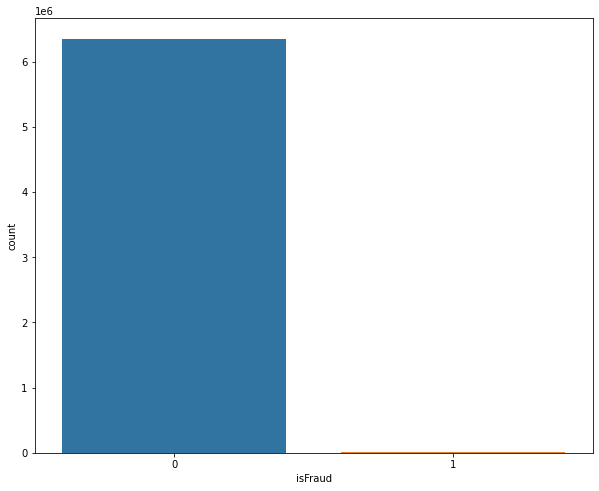

In [247]:
# for isFraud 
plt.figure(figsize=(10,8))
sns.countplot(data=df,x=df['isFraud'])

* we can see the target column is imbalanced, it is an imbalanced dataset
* we need to balance the dataset, before training the model

<AxesSubplot:ylabel='Frequency'>

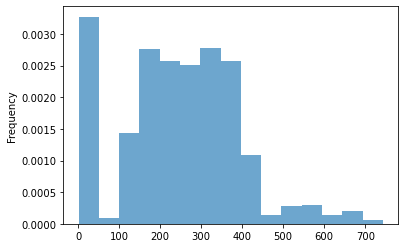

In [248]:
fig,ax=plt.subplots(figsize=(6,4))
df['step'].plot(kind="hist",density=True,alpha=0.65,bins=15)  # apha is about amount of transparency you want
# df['step'].plot(kind='kde')

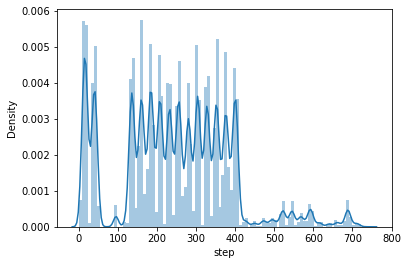

In [249]:
sns.distplot(df['step'],bins=100)
plt.show()

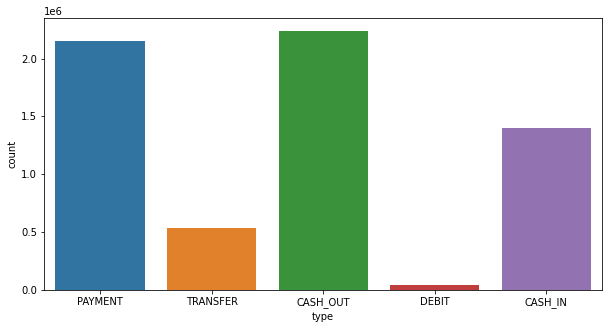

In [250]:
# for type variable
plt.figure(figsize=(10,5))
sns.countplot(data=df,x=df['type'])
total = len(df['type'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

* we can see cash out and payment are equal in amounts
* debit type is very minimal

### Bivariate analysis

<AxesSubplot:xlabel='type', ylabel='amount'>

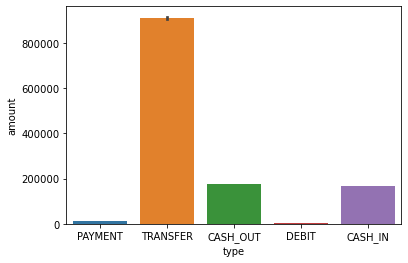

In [251]:
sns.barplot(x='type',y='amount',data=df)

### most amount is being sent to the recipient using 'transfer' type

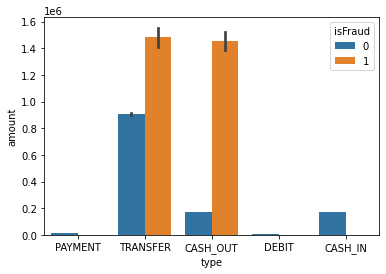

In [254]:
sns.barplot(data=df,x='type',y='amount',hue='isFraud')
plt.show()

<AxesSubplot:xlabel='step', ylabel='amount'>

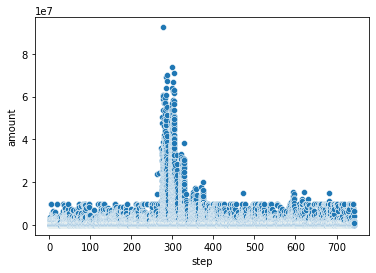

In [150]:
sns.scatterplot(x='step',y='amount',data=df)

* step value 300 indicates more amount being transferred. 

<AxesSubplot:title={'center':'amount'}, xlabel='isFraud'>

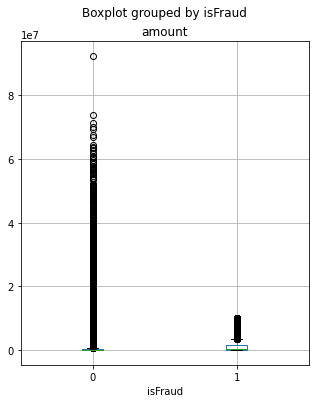

In [152]:
df.boxplot(column='amount',by='isFraud',figsize=(5,6))

* very large amounts are not effected by frauds
* low amounts are getting effecting by frauds

<AxesSubplot:title={'center':'step'}, xlabel='isFraud'>

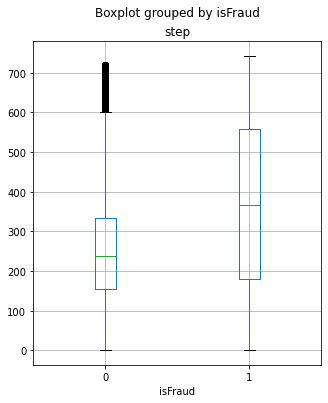

In [153]:
df.boxplot(column='step',by='isFraud',figsize=(5,6))

* most frauds are taken above 300 steps

## Checking for multicollinearity

In [158]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif=pd.DataFrame()
    vif['variables']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    return vif

In [160]:
# multicollinearity can be checked using VIF (variance inflation factor)
X=df[['step','amount','oldbalanceOrg','newbalanceOrig']]
calculate_vif(X)

,variables,VIF
0,step,1.135626
1,amount,1.081428
2,oldbalanceOrg,456.441542
3,newbalanceOrig,457.001203


* we can remove one of the variables, since oldbalanceOrg and newbalanceOrig are having high collinearity with others, we can remove one of them

In [161]:
X['transferred_amount']=X['oldbalanceOrg']-X['newbalanceOrig']

In [163]:
Y=pd.DataFrame({"trans_amount":X['transferred_amount'],"amount":X['amount']})

In [164]:
Y

,trans_amount,amount
0,9839.64,9839.64
1,1864.28,1864.28
2,181.00,181.00
3,181.00,181.00
4,11668.14,11668.14
...,...,...
6362615,339682.13,339682.13
6362616,6311409.28,6311409.28
6362617,6311409.28,6311409.28
6362618,850002.52,850002.52


In [165]:
# let's check correlation
correlation=df.corr()


In [166]:
correlation

,step,amount,oldbalanceOrg,newbalanceOrig,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,-0.008148
isFraud,0.031578,0.076688,0.010154,-0.008148,1.000000


In [168]:
correlation['isFraud'].sort_values(ascending=True)

newbalanceOrig   -0.008148
oldbalanceOrg     0.010154
step              0.031578
amount            0.076688
isFraud           1.000000
Name: isFraud, dtype: float64

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True)

In [170]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0
2,1,TRANSFER,181.00,181.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,1


### Encoding the data

In [171]:
# we need to encode type column, we can do one hot encoding
one_hot_data=pd.get_dummies(df,columns=['type'])

In [172]:
one_hot_data

,step,amount,oldbalanceOrg,newbalanceOrig,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0,0,0,0,1,0
2,1,181.00,181.00,0.00,1,0,0,0,0,1
3,1,181.00,181.00,0.00,1,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,1,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,1,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,1,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,1,0,0,0,0,1


### Splitting of data

In [173]:
X=one_hot_data.drop(['isFraud'],axis=1)
y=one_hot_data['isFraud']

In [174]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=11)

In [177]:
print(X_train.shape,X_test.shape)

(4453834, 9) (1908786, 9)


### Balance the dataset 

In [179]:
# here we ae using SMOTEENN
from imblearn.combine import SMOTEENN
smt=SMOTEENN(sampling_strategy='all')
X_smt,y_smt=smt.fit_resample(X_train,y_train)

In [181]:
from collections import Counter
print("y train: ",Counter(y_train))
print("y test: ",Counter(y_smt))

y train:  Counter({0: 4448061, 1: 5773})
y test:  Counter({1: 4434454, 0: 4417640})


In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score

## Scaling the data

In [190]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit(X_train)
X_smt_scaled=scaler.transform(X_smt)
X_test_scaled=scaler.transform(X_test)

In [194]:
lr=LogisticRegression()
lr.fit(X_smt_scaled,y_smt)
predicted_values=lr.predict(X_test)

In [201]:
f1score_lr=f1_score(y_test,predicted_values)
accuracyscore_lr=accuracy_score(y_test,predicted_values)
aurocscore_lr=roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])

In [202]:
print("f1-score: ",f1score_lr)
print("accuracy-score: ",accuracyscore_lr)
print("auroc score: ",aurocscore_lr)

f1-score:  0.005433617409015383
accuracy-score:  0.5333840461948065
auroc score:  0.7649726904159091


In [205]:
dt=DecisionTreeClassifier()
dt.fit(X_smt,y_smt)
predicted_values=dt.predict(X_test)
f1score_dt=f1_score(y_test,predicted_values)
accuracyscore_dt=accuracy_score(y_test,predicted_values)
aurocscore_dt=roc_auc_score(y_test,dt.predict_proba(X_test)[:,1])

In [206]:
print("f1-score: ",f1score_dt)
print("accuracy-score: ",accuracyscore_dt)
print("auroc score: ",aurocscore_dt)

f1-score:  0.8181143281365999
accuracy-score:  0.9994865846669034
auroc score:  0.9514442065485746


* we can see that auroc score of decision tree classifier is 95%, which is pretty much good

### Final Conclusion
1. as the steps increases the percentage of getting fraud also increases
2. most amount of frauds are being taken after 13 days, considering each step as hour, i.e at the middle of the month
3. amount that is being transferred is less in the case, if the transaction is fraud.
4. call in early hours or on begining of the monthS.